Found 3352 files belonging to 7 classes.
Using 2682 files for training.


2024-02-14 15:28:43.994375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 15:28:43.994476: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 15:28:43.994526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 15:28:44.256680: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 15:28:44.256729: I tensorflow/core/common_runtime/gpu/gpu

Found 3352 files belonging to 7 classes.
Using 670 files for validation.
44107200/44107200 [==============================] - 25s 1us/step


Epoch 1/30


2024-02-14 15:29:26.721791: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-14 15:29:27.006545: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-14 15:29:29.731916: I external/local_xla/xla/service/service.cc:168] XLA service 0xaa10670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-14 15:29:29.731956: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-02-14 15:29:29.744498: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707904769.817558    2662 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 [==============================] - 45s 414ms/step - loss: 1.5121 - accuracy: 0.5354 - val_loss: 0.7112 - val_accuracy: 0.7612 - lr: 0.0010
Epoch 2/30
84/84 [==============================] - 32s 378ms/step - loss: 0.8929 - accuracy: 0.7136 - val_loss: 0.3973 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 3/30
84/84 [==============================] - 32s 377ms/step - loss: 0.7320 - accuracy: 0.7688 - val_loss: 0.3635 - val_accuracy: 0.8746 - lr: 0.0010
Epoch 4/30
84/84 [==============================] - 30s 356ms/step - loss: 0.5841 - accuracy: 0.8098 - val_loss: 0.3021 - val_accuracy: 0.9045 - lr: 0.0010
Epoch 5/30
84/84 [==============================] - 28s 329ms/step - loss: 0.5136 - accuracy: 0.8367 - val_loss: 0.2668 - val_accuracy: 0.9134 - lr: 0.0010
Epoch 6/30
84/84 [==============================] - 28s 327ms/step - loss: 0.4592 - accuracy: 0.8475 - val_loss: 0.2449 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 7/30
84/84 [==============================] - 28s 328ms/step - loss: 

/home/rishi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


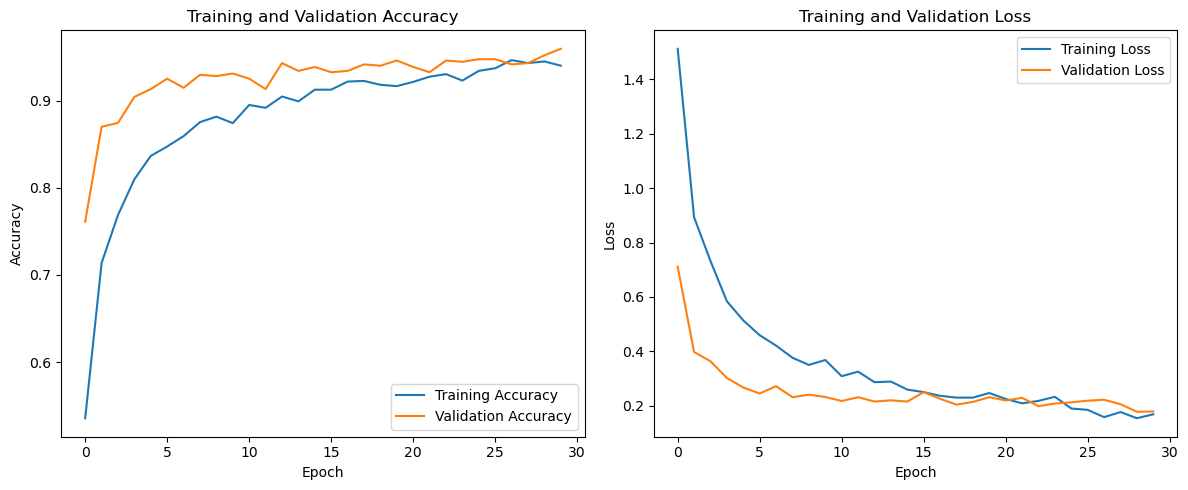

In [4]:
#import tensorrt as trt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,Rescaling
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import os

#use if using gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
  except RuntimeError as e:
    print(e)

# Set the path to your dataset
train_data_dir = os.path.join(os.getcwd(),'dataset/train')
test_data_dir = os.path.join(os.getcwd(),'dataset/test')
# Define parameters
img_width, img_height = 300, 300  # EfficientNet input size
input_shape = (img_width, img_height, 3)
epochs = 30
batch_size = 32

train_generator=tf.keras.utils.image_dataset_from_directory(train_data_dir,validation_split=0.2,
                                                            seed=123,subset="training",
                                                            image_size=(img_width, img_height),
                                                            batch_size=batch_size,
                                                            label_mode='categorical'
                                                            )

val_generator=tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                          validation_split=0.2,
                                                          seed=123,subset="validation",
                                                          image_size=(img_width, img_height),
                                                          batch_size=batch_size,
                                                          label_mode='categorical')

# Use EfficientNetB3 as a base model
base_model = EfficientNetB3(weights='imagenet', include_top=False)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(Rescaling(1./255,input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # Assuming you have 7 classes

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
    )

# Save the model
model.save('car_brand_classifier_advanced_model.h5')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
#Load model to test and generate a confusion matrix
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.preprocessing import image
model=load_model('car_brand_classifier_advanced_model.h5')
imsize=(300,300)
labels=['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']

In [6]:
import numpy as np
#labels to append results to
predicted_label=[]
true_label=[]

for i in sorted(os.listdir('dataset/test')):#Iterate through each class in the dataset
    for j in os.listdir(os.path.join('dataset/test',i)):#Iterate through each image in the class
        
        #load and resize image
        filename=os.path.join('dataset/test/',i,j)
        img=image.load_img(filename, target_size=imsize)
        resized_img=image.img_to_array(img)
        final=np.expand_dims(resized_img,axis=0)

        #Feed loaded image to model and get predictions
        predictions=model.predict(final)

        #Append class with highest confidence to predicted label and i(class) to the true label
        true_label.append(sorted(os.listdir('dataset/test')).index(i))
        predicted_label.append(list(predictions[0]).index(max(predictions[0])))

1/1 [==============================] - 0s 22ms/step


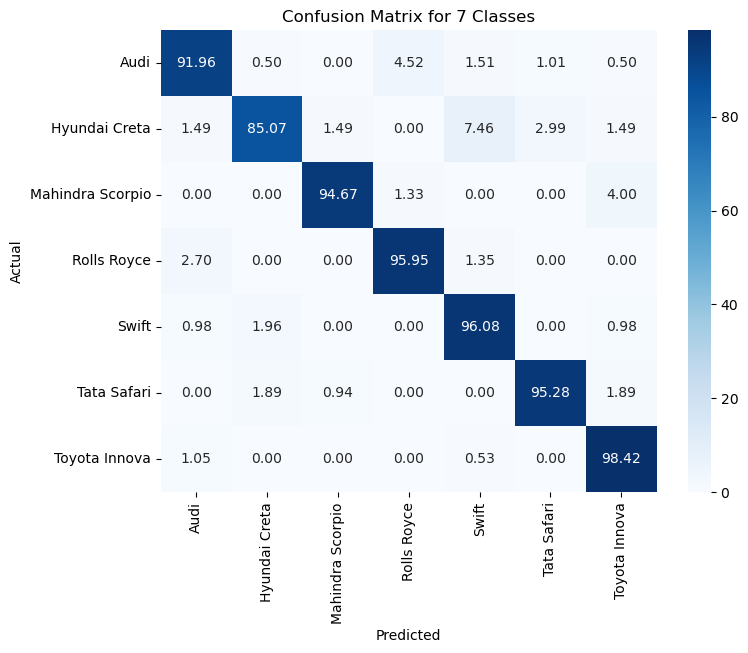

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(true_label, predicted_label)
cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100 #Calculate values in terms of percentages

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentages, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 7 Classes')
plt.show()